In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [2]:
batch_size = 64
num_epochs = 30
early_stop_patience = 5
data_dir = "../data/animals10"

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))
model.to(device)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# for param in model.parameters():
#     param.requires_grad = True

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, test_losses, train_accs, test_accs = [], [], [], []
best_loss = float('inf')
patience = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item()
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = val_correct / val_total
    test_losses.append(val_loss / len(test_loader))
    test_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Acc: {val_acc:.4f}")

    # Early stopping
    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        best_model = model.state_dict()
        patience = 0
    else:
        patience += 1
        if patience >= early_stop_patience:
            print("Early stopping activated.")
            break

Epoch 01 | Train Loss: 1.8387 | Train Acc: 0.3504 | Test Loss: 1.5867 | Test Acc: 0.4465
Epoch 02 | Train Loss: 1.3772 | Train Acc: 0.5247 | Test Loss: 1.2571 | Test Acc: 0.5655
Epoch 03 | Train Loss: 1.1168 | Train Acc: 0.6171 | Test Loss: 1.1226 | Test Acc: 0.6081
Epoch 04 | Train Loss: 0.9632 | Train Acc: 0.6697 | Test Loss: 0.9976 | Test Acc: 0.6644
Epoch 05 | Train Loss: 0.8302 | Train Acc: 0.7165 | Test Loss: 0.9594 | Test Acc: 0.6623
Epoch 06 | Train Loss: 0.7240 | Train Acc: 0.7526 | Test Loss: 0.8503 | Test Acc: 0.7212
Epoch 07 | Train Loss: 0.6285 | Train Acc: 0.7850 | Test Loss: 0.7977 | Test Acc: 0.7378
Epoch 08 | Train Loss: 0.5356 | Train Acc: 0.8163 | Test Loss: 0.9364 | Test Acc: 0.6974
Epoch 09 | Train Loss: 0.4508 | Train Acc: 0.8462 | Test Loss: 0.7939 | Test Acc: 0.7520
Epoch 10 | Train Loss: 0.3857 | Train Acc: 0.8678 | Test Loss: 0.8136 | Test Acc: 0.7531
Epoch 11 | Train Loss: 0.3176 | Train Acc: 0.8902 | Test Loss: 0.8555 | Test Acc: 0.7537
Epoch 12 | Train Loss

In [6]:
# Evaluación final
model.load_state_dict(best_model)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

print(f"\n✅ Final Test Accuracy: {correct / total:.4f}")


✅ Final Test Accuracy: 0.7451


In [7]:
from sklearn.metrics import classification_report

# Calcular predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

# Imprimir reporte de clasificación
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes if hasattr(test_dataset, 'classes') else [str(i) for i in range(10)]))



📊 Classification Report:
              precision    recall  f1-score   support

   butterfly       0.86      0.81      0.83       423
         cat       0.67      0.49      0.57       334
     chicken       0.90      0.78      0.83       620
         cow       0.66      0.67      0.67       374
         dog       0.77      0.68      0.72       973
    elephant       0.75      0.68      0.71       290
       horse       0.78      0.76      0.77       525
       ragno       0.84      0.88      0.86       965
       sheep       0.54      0.76      0.63       364
    squirrel       0.54      0.77      0.63       373

    accuracy                           0.75      5241
   macro avg       0.73      0.73      0.72      5241
weighted avg       0.76      0.75      0.75      5241



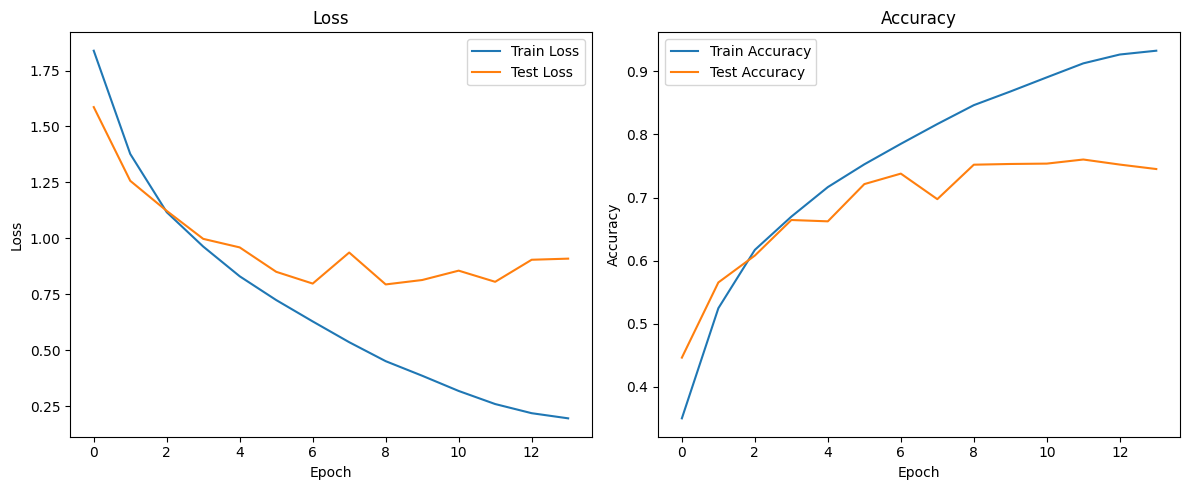

In [8]:
# Gráficas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
print(train_losses)
print(test_losses)
print(train_accs)
print(test_accs)

[1.838733171180981, 1.3772234187983885, 1.1167610433043502, 0.9631661427457158, 0.8301991548661779, 0.7239718738852478, 0.6284628279688882, 0.5355987866386408, 0.4507541520203032, 0.3856652666155885, 0.31758755493182234, 0.2591254729550423, 0.21820640743414804, 0.1951975288414737]
[1.5866871905036088, 1.2571382202753207, 1.1226165890693665, 0.9975831341452714, 0.9593713483432444, 0.8502837628489588, 0.7976870580417353, 0.9364390645812197, 0.7938940346059276, 0.8136030482809719, 0.8554685304804546, 0.8056219309204962, 0.9041800517134551, 0.9091522086684297]
[0.3503677524118827, 0.5247397077084727, 0.6171076511605693, 0.6697392301079377, 0.7164963224758811, 0.7525551628617824, 0.7849842391823478, 0.8163148342726144, 0.8462126277581431, 0.8678001719361925, 0.8902473970770848, 0.9124080618970293, 0.9264017575699685, 0.9324195243098672]
[0.44647967945048656, 0.5655409273039497, 0.6080900591490174, 0.6643770272848692, 0.6622781911848884, 0.7212364052661706, 0.7378362907842015, 0.697385995039